#### Modelling the Photic Zone using CMEMS Data Store
##### Prerequisites:
1) __Wekeo account:__ Create an account via "Register" [here](https://www.wekeo.eu/)
2) __Copernicus Marine account:__ Create an account [here](https://data.marine.copernicus.eu/register)
3) __xcube_cmems plugin__ must be installed in the active environment. (Currently we are working in "wekeolab" environment:

   execute first in terminal <code style="background:black;color:white">conda activate wekeolab</code>

   execute second the following code in you terminal (with wekeolab conda env activated):
 
   <code style="background:black;color:white">conda install -c conda-forge xcube-cmems</code><br>
   <code style="background:black;color:white">conda install openeo</code><br>
   <code style="background:black;color:white">conda install bottleneck</code>

In [1]:
# mandatory xcube store imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from xcube.core.dsio import open_cube
from xcube.core.geom import clip_dataset_by_geometry

# Utilities for notebook visualization.
# JSON provides pretty-printing of Python lists and dictionaries.
from IPython.display import JSON

import os
import numpy as np
import xarray as xr
import rioxarray
import shapely
#import openeo
import bottleneck
from xcube_cmems.store import CmemsDataStore
import xcube_cmems

In [2]:
# write in your CMEMS username and password
user = "nbrautigam"
pwrd = "Bading42!Bading42!"

os.environ["CMEMS_USERNAME"] =  user
os.environ["CMEMS_PASSWORD"] = pwrd

In [3]:
# check that "cmems" is an option under root
# if "cmems" is not listed, make sure to install xcube_cmems plugin in the correct env and restart your kernel!
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

In [12]:
## Trying to list all datastore ids - return to this
#cmems_store =  CmemsDataStore()
#cmems_ids = cmems_store.list_data_ids()
#cmems_ids = cmems_store.get_datasets_with_titles()
#cmems_store

In [24]:
#cmems_store.get_open_data_params_schema("cmems_obs-oc_bal_bgc-transp_nrt_l3-olci-300m_P1D")

In [4]:
# create a data store instance as variable
store = new_data_store("cmems")
store

In [5]:
# replace "id" with dataset id from Copernicus Marine
id = 'cmems_obs-oc_bal_bgc-transp_nrt_l3-olci-300m_P1D'

# replace with variables of interest from dataset
# if multiple variables: ['x','y']
# if ALL variable in dataset: []
varbs = ['KD490']

# create bounding box [W,S,E,N]
bbox = [9.5, 55, 13, 60]

# enter start and end dates
start = "2024-05-01"
end = "2024-05-31"

ds = store.open_data(
    id,
    variable_names=varbs,
    bbox=bbox,
    time_range=(start, end),
)
ds

WARNING - 2025-04-10T08:29:55Z - Deprecation warning for option 'no_metadata_cache'. This option will no longer be available in copernicusmarine>=2.0.0. Please refer to the documentation when the new major version is released for more information.
Fetching catalog: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it]
INFO - 2025-04-10T08:30:04Z - Dataset version was not specified, the latest one was selected: "202207"
INFO - 2025-04-10T08:30:04Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2025-04-10T08:30:07Z - Service was not specified, the default one was selected: "arco-geo-series"


<xarray.Dataset> Size: 151MB
Dimensions:    (time: 31, latitude: 1856, longitude: 658)
Coordinates:
  * latitude   (latitude) float32 7kB 55.0 55.0 55.01 55.01 ... 59.99 60.0 60.0
  * longitude  (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time       (time) datetime64[ns] 248B 2024-05-01 2024-05-02 ... 2024-05-31
Data variables:
    KD490      (time, latitude, longitude) float32 151MB ...
Attributes: (12/38)
    BALMLP_code_version:     BAL MLP ENSEMBLE 2021
    Conventions:             CF-1.4
    area:                    bal
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_NRT_009_131
    cmems_production_unit:   OC-CNR-ROMA-IT
    contact:                 technical@gos.artov.isac.cnr.it
    ...                      ...
    southernmost_latitude:   53.25
    start_date:              2023-04-18
    stop_date:               2023-04-18
    timeliness:              NR
    title:                   cmems_obs-oc_bal_bgc-transp_nrt_l3-olci-300m_P1D
    westernmost_longitude:   9.25

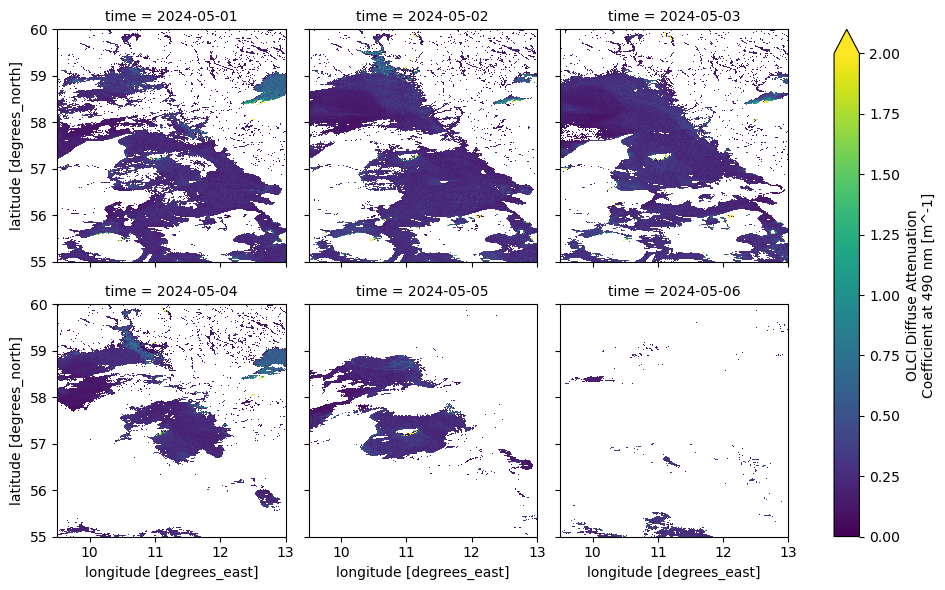

In [5]:
testplot = ds.KD490.isel(time=slice(0,6)).plot(x='longitude', y='latitude', col='time', col_wrap=3, vmin=0, vmax=2)

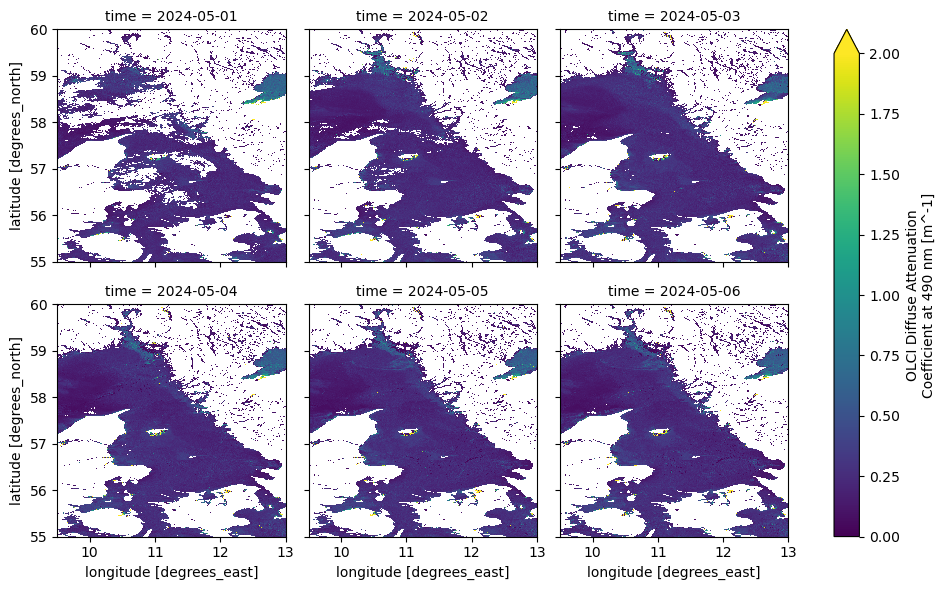

In [6]:
## forward-fill all variables in time-series. 
## Let's also look at the first 6 days of data to visually verify that we're progressively filling in gaps
ds_fill = ds.ffill(dim='time', limit=None)
testplot = ds_fill.KD490.isel(time=slice(0,6)).plot(x='longitude', y='latitude', col='time', col_wrap=3, vmin=0, vmax=2)

In [7]:
## convert KD490 to euphotic zone based on Vivien's simple algorithm
## Check that Variable "Zeu" has been added to the dataset
ds_fill = ds_fill.assign(Zeu=6.8/(ds_fill['KD490']))
ds_fill

<xarray.Dataset> Size: 303MB
Dimensions:    (latitude: 1856, longitude: 658, time: 31)
Coordinates:
  * latitude   (latitude) float32 7kB 55.0 55.0 55.01 55.01 ... 59.99 60.0 60.0
  * longitude  (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time       (time) datetime64[ns] 248B 2024-05-01 2024-05-02 ... 2024-05-31
Data variables:
    KD490      (time, latitude, longitude) float32 151MB nan nan nan ... nan nan
    Zeu        (time, latitude, longitude) float32 151MB nan nan nan ... nan nan
Attributes: (12/38)
    BALMLP_code_version:     BAL MLP ENSEMBLE 2021
    Conventions:             CF-1.4
    area:                    bal
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_NRT_009_131
    cmems_production_unit:   OC-CNR-ROMA-IT
    contact:                 technical@gos.artov.isac.cnr.it
    ...                      ...
    southernmost_latitude:   53.25
    start_date:              2023-04-18
    stop_date:               2023-04-18
    timeliness:              NR
    title:                   cmems_obs-oc_bal_bgc-transp_nrt_l3-olci-300m_P1D
    westernmost_longitude:   9.25

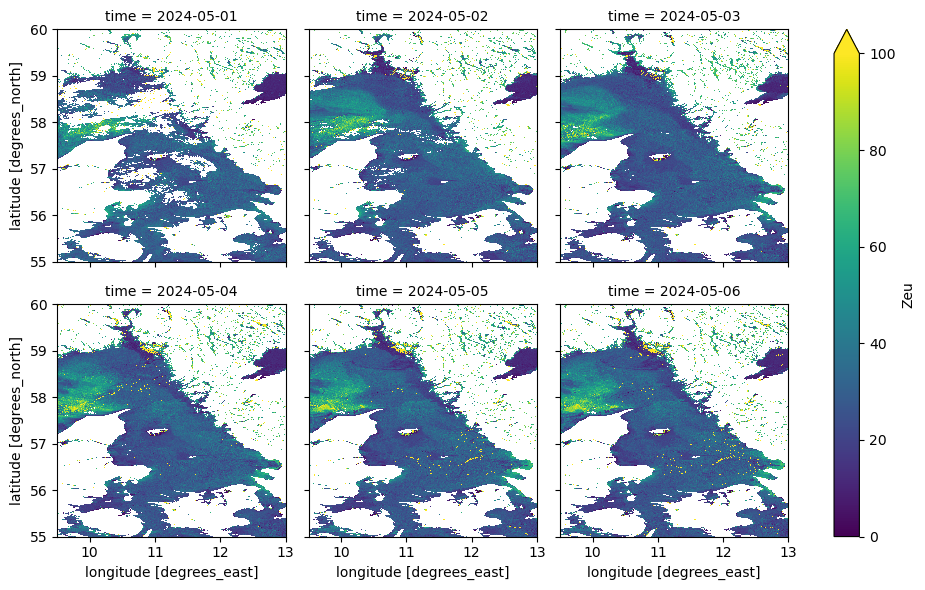

In [20]:
## Plot the first 6 days of the euphotic zone time series for a visual inspection
testplot = ds_fill.Zeu.isel(time=slice(0,6)).plot(x='longitude', y='latitude', col='time', col_wrap=3, vmin=0, vmax=100)

In [8]:
# read in EMODnet bathymetry
bathy = os.path.join('external_data', 'Area of interest_220222.tif')

In [9]:
# Open into an xarray.DataArray
bathy_da = rioxarray.open_rasterio(bathy)

# invert height/depth - meters below sea level become positive
bathy_da = bathy_da*-1

# Covert our xarray.DataArray into a xarray.Dataset
bathy_ds = bathy_da.to_dataset('band')

# Rename the variable to a more useful name
bathy_ds = bathy_ds.rename({1: 'mbsl'})

# Slice in space
bathy_ds = bathy_ds.sel(y=slice(60,55), x=slice(9.5,13))
bathy_ds

<xarray.Dataset> Size: 16MB
Dimensions:      (y: 1957, x: 2006)
Coordinates:
  * x            (x) float64 16kB 10.04 10.04 10.04 10.04 ... 12.12 12.12 12.13
  * y            (y) float64 16kB 59.21 59.2 59.2 59.2 ... 57.17 57.17 57.17
    spatial_ref  int64 8B 0
Data variables:
    mbsl         (y, x) float32 16MB -170.1 -167.4 -160.7 ... 14.35 14.65 14.55

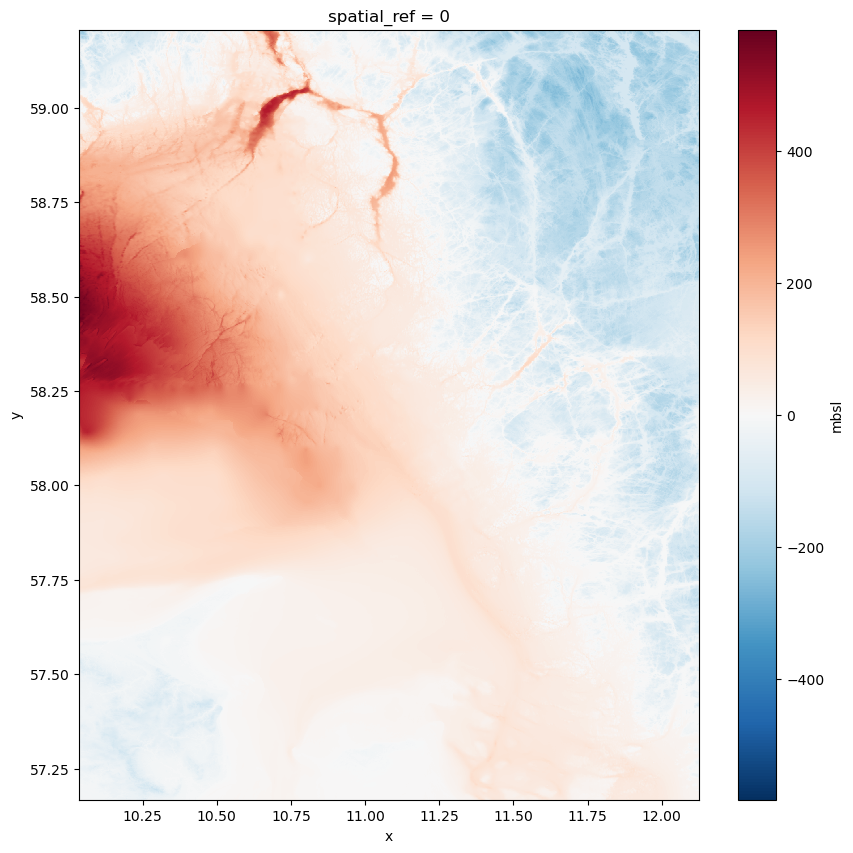

In [10]:
# plot bathymetry to check data
bathy_ds.mbsl.plot(figsize=(10,10))

In [11]:
## Now we need to reproject our bathymetry data to the correct CRS, as well as resample the pixel resolution to match that of our cmems data
## Import some grid mapping tools
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space

import copy
import matplotlib
import matplotlib.pyplot as plt

In [12]:
# Create grid maps for both cmems dataset and bathymetry
ds_gm = GridMapping.from_dataset(ds_fill)
bathy_gm = GridMapping.from_dataset(bathy_ds)

# check grid coords for bathymetry
x_coords, y_coords = bathy_gm.xy_coords
y_coords

<xarray.DataArray 'xy_coords' (y: 1957, x: 2006)> Size: 31MB
dask.array<getitem, shape=(1957, 2006), dtype=float64, chunksize=(1957, 2006), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

/opt/conda/envs/wekeolab/lib/python3.11/site-packages/dask/array/chunk.py:138: RuntimeWarning: Mean of empty slice
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)), **kwargs)


In [13]:
## check grid coords for cmems dataset
## You can see that the "shape" of the fata is different - we need to match up the pixels in space!
x_coords, y_coords = ds_gm.xy_coords
y_coords

<xarray.DataArray 'xy_coords' (latitude: 1856, longitude: 658)> Size: 5MB
dask.array<getitem, shape=(1856, 658), dtype=float32, chunksize=(1856, 658), chunktype=numpy.ndarray>
Dimensions without coordinates: latitude, longitude

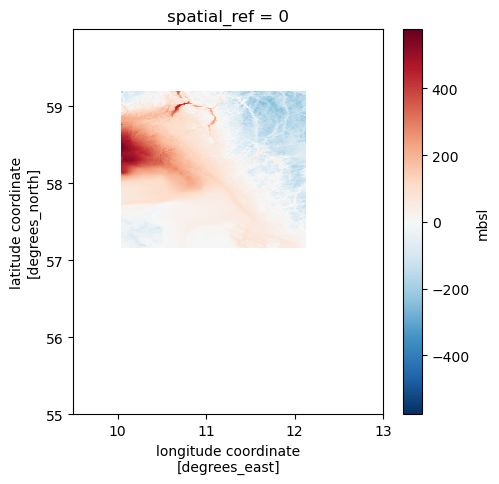

In [14]:
# Reproject bathy to cmems resolution and gridding
bathy_re = resample_in_space(bathy_ds, source_gm=bathy_gm, target_gm=ds_gm)

# check bathy to make sure it still looks ok
bathy_re.mbsl.plot(figsize=(5,5))

In [15]:
# check bathy grid map to make sure it matches cmems dataset
bathy_gm1 = GridMapping.from_dataset(bathy_re)
x_coords, y_coords = bathy_gm1.xy_coords
y_coords

<xarray.DataArray 'xy_coords' (y: 1856, x: 658)> Size: 10MB
dask.array<getitem, shape=(1856, 658), dtype=float64, chunksize=(1856, 658), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

In [16]:
# fix bathy lat/long coords to match cmems before joining into a new dataset
bathy_re = bathy_re.rename({'x': 'longitude','y': 'latitude'})
bathy_re['latitude'] = ds_fill['latitude']
bathy_re['longitude'] = ds_fill['longitude']

In [17]:
# combine bathy and cmems to single dataset
comb1 = [[ds_fill],[bathy_re]]
comb1 = xr.combine_nested(comb1, concat_dim=[None,None], coords=['latitude','longitude'])
comb1

<xarray.Dataset> Size: 308MB
Dimensions:      (latitude: 1856, longitude: 658, time: 31)
Coordinates:
  * latitude     (latitude) float32 7kB 55.0 55.0 55.01 ... 59.99 60.0 60.0
  * longitude    (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time         (time) datetime64[ns] 248B 2024-05-01 2024-05-02 ... 2024-05-31
    spatial_ref  int64 8B 0
Data variables:
    KD490        (time, latitude, longitude) float32 151MB nan nan ... nan nan
    Zeu          (time, latitude, longitude) float32 151MB nan nan ... nan nan
    mbsl         (latitude, longitude) float32 5MB dask.array<chunksize=(1856, 658), meta=np.ndarray>
    crs          int64 8B 0

In [18]:
# calculate new variable for photic zone
## is this right? Theoretically is you subtract bathy from Zeu all resulting positive values should be photic zone...
## Zeu_norm is the theoretical penetration of light BELOW the ocean bottom, if positive (+) this cell is part of the Zeu
comb1 = comb1.assign(Zeu_norm=comb1['Zeu']-comb1['mbsl'])
## something is wrong here with Zeu_percent
comb1 = comb1.assign(Zeu_percent=(((comb1['Zeu_norm']) / (comb1['Zeu']))*100))
comb1 = comb1.transpose('time',...)
comb1

<xarray.Dataset> Size: 611MB
Dimensions:      (latitude: 1856, longitude: 658, time: 31)
Coordinates:
  * latitude     (latitude) float32 7kB 55.0 55.0 55.01 ... 59.99 60.0 60.0
  * longitude    (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time         (time) datetime64[ns] 248B 2024-05-01 2024-05-02 ... 2024-05-31
    spatial_ref  int64 8B 0
Data variables:
    KD490        (time, latitude, longitude) float32 151MB nan nan ... nan nan
    Zeu          (time, latitude, longitude) float32 151MB nan nan ... nan nan
    mbsl         (latitude, longitude) float32 5MB dask.array<chunksize=(1856, 658), meta=np.ndarray>
    crs          int64 8B 0
    Zeu_norm     (time, latitude, longitude) float32 151MB dask.array<chunksize=(31, 1856, 658), meta=np.ndarray>
    Zeu_percent  (time, latitude, longitude) float32 151MB dask.array<chunksize=(31, 1856, 658), meta=np.ndarray>

In [19]:
Zeu_norm = comb1.Zeu_norm
#Zeu_norm = Zeu_norm.where(False, 1)
Zeu_per = comb1.Zeu_percent
Zeu = xr.combine_by_coords([Zeu_norm, Zeu_per], compat='broadcast_equals')
Zeu = Zeu.where(Zeu.Zeu_norm >= 0)
Zeu = Zeu.assign(Zeu_bin = Zeu['Zeu_norm'].where(Zeu.Zeu_norm >=0, 1))
Zeu

<xarray.Dataset> Size: 454MB
Dimensions:      (time: 31, latitude: 1856, longitude: 658)
Coordinates:
  * latitude     (latitude) float32 7kB 55.0 55.0 55.01 ... 59.99 60.0 60.0
  * longitude    (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time         (time) datetime64[ns] 248B 2024-05-01 2024-05-02 ... 2024-05-31
    spatial_ref  int64 8B 0
Data variables:
    Zeu_norm     (time, latitude, longitude) float32 151MB dask.array<chunksize=(31, 1856, 658), meta=np.ndarray>
    Zeu_percent  (time, latitude, longitude) float32 151MB dask.array<chunksize=(31, 1856, 658), meta=np.ndarray>
    Zeu_bin      (time, latitude, longitude) float32 151MB dask.array<chunksize=(31, 1856, 658), meta=np.ndarray>

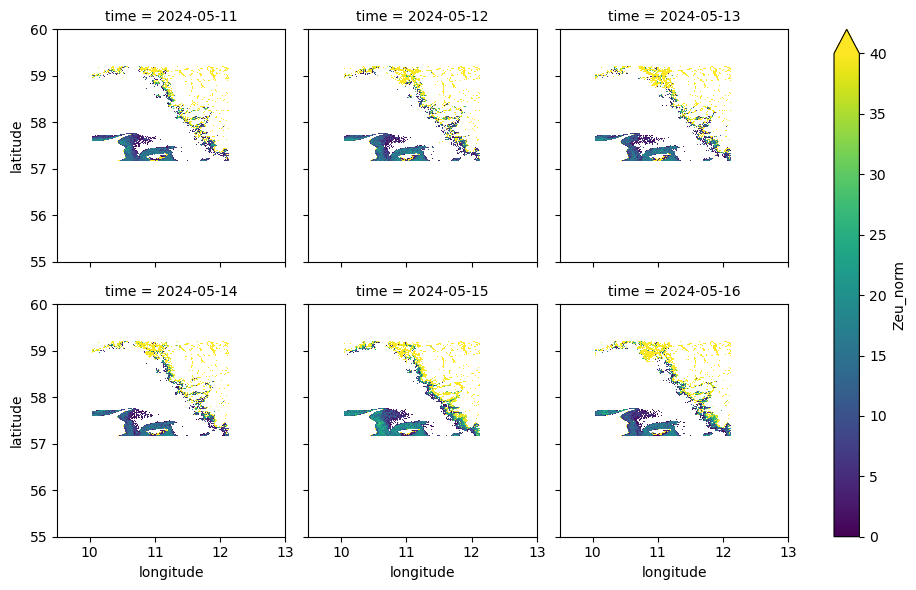

In [71]:
testplot = Zeu.Zeu_norm.isel(time=slice(10,16)).plot(x='longitude', y='latitude', col='time', col_wrap=3, vmin=0, vmax=40)

In [20]:
comb2 = comb1.drop_vars(['Zeu_norm', 'Zeu_percent'])
Zeu_ds = xr.combine_by_coords([comb2, Zeu], compat='broadcast_equals')
Zeu_ds

<xarray.Dataset> Size: 762MB
Dimensions:      (latitude: 1856, longitude: 658, time: 31)
Coordinates:
  * latitude     (latitude) float32 7kB 55.0 55.0 55.01 ... 59.99 60.0 60.0
  * longitude    (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time         (time) datetime64[ns] 248B 2024-05-01 2024-05-02 ... 2024-05-31
    spatial_ref  int64 8B 0
Data variables:
    KD490        (time, latitude, longitude) float32 151MB nan nan ... nan nan
    Zeu          (time, latitude, longitude) float32 151MB nan nan ... nan nan
    mbsl         (latitude, longitude) float32 5MB dask.array<chunksize=(1856, 658), meta=np.ndarray>
    crs          int64 8B 0
    Zeu_norm     (time, latitude, longitude) float32 151MB dask.array<chunksize=(31, 1856, 658), meta=np.ndarray>
    Zeu_percent  (time, latitude, longitude) float32 151MB dask.array<chunksize=(31, 1856, 658), meta=np.ndarray>
    Zeu_bin      (time, latitude, longitude) float32 151MB dask.array<chunksize=(31, 1856, 658), meta=np.ndarray>

In [21]:
# Import libraries for xcube Viewer
import os

usernm = 'noahbr'

from xcube.webapi.viewer import Viewer 
os.environ["XCUBE_JUPYTER_LAB_URL"] = "https://jupyterhub.prod.wekeo2.eu/user/" + usernm + "/"

In [22]:
# set styles and initialize Viewer object
## need to work on styles!
viewer = Viewer(server_config={
#    "port": 9002,
    "Styles": [
        {
            "Identifier": "pz",
            "ColorMappings": {
#            "color_mappings": {
                "KD490": {
                    "ValueRange": [0, 1],
                    "ColorBar": "viridis"},
                "Zeu": {
                    "ValueRange": [0, 100],
                    "ColorBar": "viridis"},               
                "Zeu_norm": {
                    "ValueRange": [0, 40],
                    "ColorBar": "thermal"},
                "Zeu_percent": {
                    "ValueRange": [0, 100],
                    "ColorBar": "thermal"},
                "mbsl": {
                    "ValueRange": [0, 500],
                    "ColorBar": "terrain_r"
                },
            }
        }
    ]
})

404 GET /viewer/config/config.json (127.0.0.1): xcube viewer has not been been configured
404 GET /viewer/config/config.json (127.0.0.1) 44.51ms
501 GET /viewer/state?key=sentinel (127.0.0.1) 0.33ms
no chunks found for dimension 'time' of variable 'mbsl' in time-chunked dataset 'e777e296-efdd-4711-9221-14e0fee437ec'
404 GET /viewer/ext/contributions (127.0.0.1) 80.69ms
/opt/conda/envs/wekeolab/lib/python3.11/site-packages/dask/array/chunk.py:138: RuntimeWarning: Mean of empty slice
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)), **kwargs)
/opt/conda/envs/wekeolab/lib/python3.11/site-packages/dask/array/chunk.py:138: RuntimeWarning: Mean of empty slice
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)), **kwargs)
/opt/conda/envs/wekeolab/lib/python3.11/site-packages/dask/array/chunk.py:138: RuntimeWarning: Mean of empty slice
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)), **kwargs)
/opt/conda/envs/wekeol

In [23]:
# replace "dsview" with dataset to visualize
dsview = Zeu_ds

viewer.add_dataset(dsview, style="pz")

'e777e296-efdd-4711-9221-14e0fee437ec'

In [24]:
viewer.show()